In [9]:
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Define the path to our saved models ---
model_dir = os.path.join("..", "models")

# --- Load the four essential objects ---
model = joblib.load(os.path.join(model_dir, 'tax_classifier.joblib'))
vectorizer = joblib.load(os.path.join(model_dir, 'kmer_vectorizer.joblib'))
label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.joblib'))

# Load the test data
test_data = np.load(os.path.join(model_dir, 'test_data.npz'))
X_test = test_data['X_test']
y_test = test_data['y_test']

print("Successfully loaded model and assets.")

Successfully loaded model and assets.


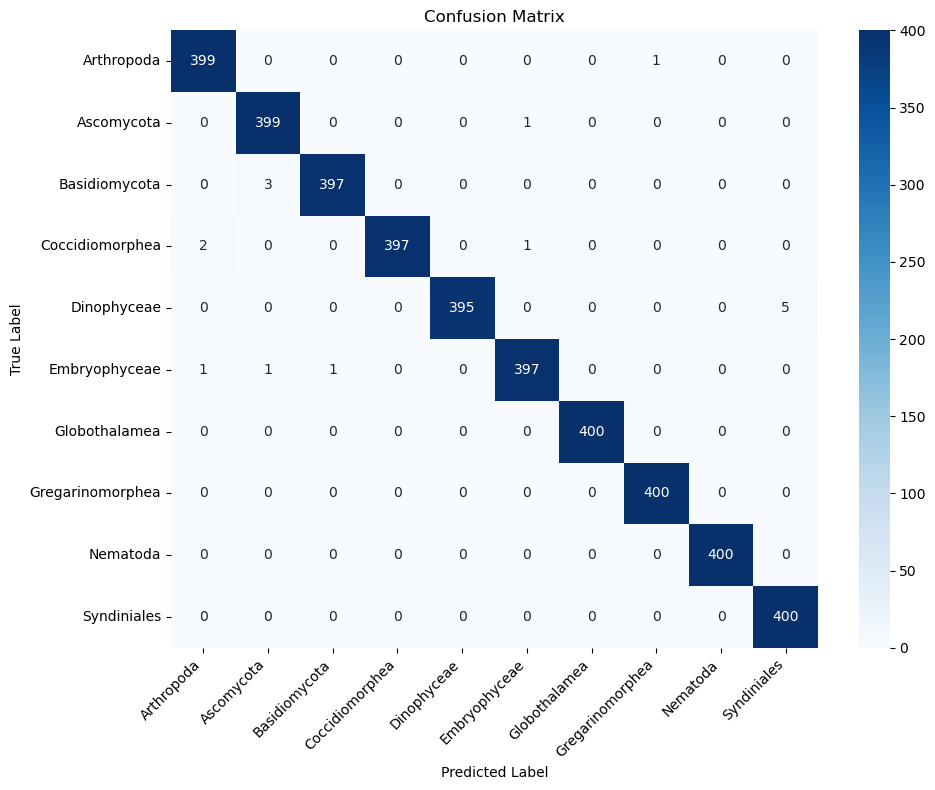

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Re-run predictions if needed (or load from previous notebook) ---
y_pred = model.predict(X_test)

# --- 1. Generate the Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_

# --- 2. Plot the Confusion Matrix for better visualization ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# --- ADD THESE IMPORT STATEMENTS AT THE TOP ---
from Bio import SeqIO
import pandas as pd
import os

# --- Phase 2: Classify the Independent Challenge Dataset ---

print("--- Loading the independent challenge OTUs ---")
challenge_otus_path = os.path.join("..", "data", "processed", "challenge_otus.fasta")

challenge_otu_data = []
# The get_kmer_features function was defined in a previous notebook. 
# We need to define it again here to use it.
def get_kmer_features(sequence, k=6):
    kmer_counts = {}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        kmer_counts[kmer] = kmer_counts.get(kmer, 0) + 1
    return kmer_counts


for record in SeqIO.parse(challenge_otus_path, "fasta"):
    header_parts = record.id.split(';size=')
    otu_id = header_parts[0]
    abundance = int(header_parts[1])
    sequence = str(record.seq)
    challenge_otu_data.append([otu_id, abundance, sequence])

challenge_df = pd.DataFrame(challenge_otu_data, columns=['otu_id', 'abundance', 'sequence'])
print(f"Loaded {len(challenge_df)} OTUs from the challenge dataset.")

# --- Apply the same feature engineering ---
print("\n--- Applying k-mer function to challenge OTUs... ---")
challenge_df['kmer_counts'] = challenge_df['sequence'].apply(lambda seq: get_kmer_features(seq, k=6))

# --- Vectorize using the EXISTING vectorizer ---
print("--- Vectorizing challenge OTU features... ---")
X_challenge_otus = vectorizer.transform(challenge_df['kmer_counts'])

# --- Make Predictions with our trained model ---
print("--- Making predictions on the challenge data... ---")
challenge_predictions_encoded = model.predict(X_challenge_otus)
challenge_predictions_decoded = label_encoder.inverse_transform(challenge_predictions_encoded)

# --- Generate the final report for the challenge dataset ---
print("--- Generating final report for challenge dataset... ---\n")
challenge_df['predicted_class'] = challenge_predictions_decoded

# --- Summary of biodiversity found in the challenge sample ---
print("--- Summary of Predicted Classes in the Challenge Sample (by abundance) ---")
challenge_biodiversity_summary = challenge_df.groupby('predicted_class')['abundance'].sum().sort_values(ascending=False)
print(challenge_biodiversity_summary)

--- Loading the independent challenge OTUs ---
Loaded 8650 OTUs from the challenge dataset.

--- Applying k-mer function to challenge OTUs... ---
--- Vectorizing challenge OTU features... ---
--- Making predictions on the challenge data... ---
--- Generating final report for challenge dataset... ---

--- Summary of Predicted Classes in the Challenge Sample (by abundance) ---
predicted_class
Arthropoda          2037
Basidiomycota       1728
Ascomycota          1609
Nematoda            1325
Globothalamea        947
Dinophyceae          789
Coccidiomorphea      651
Gregarinomorphea     439
Syndiniales          371
Embryophyceae        274
Name: abundance, dtype: int64
